In [1]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.naive_bayes import CategoricalNB, GaussianNB, BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import pipeline, preprocessing, model_selection
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.multiclass import OneVsRestClassifier
import matplotlib.pyplot as plt

## Load data

In [2]:
df = pd.read_csv("tcc_ceds_music.csv")
df.head()

,Unnamed: 0,artist_name,track_name,release_date,genre,lyrics,len,dating,violence,world/life,...,sadness,feelings,danceability,loudness,acousticness,instrumentalness,valence,energy,topic,age
0,0,mukesh,mohabbat bhi jhoothi,1950,pop,hold time feel break feel untrue convince spea...,95,0.000598,0.063746,0.000598,...,0.380299,0.117175,0.357739,0.454119,0.997992,0.901822,0.339448,0.137110,sadness,1.0
1,4,frankie laine,i believe,1950,pop,believe drop rain fall grow believe darkest ni...,51,0.035537,0.096777,0.443435,...,0.001284,0.001284,0.331745,0.647540,0.954819,0.000002,0.325021,0.263240,world/life,1.0
2,6,johnnie ray,cry,1950,pop,sweetheart send letter goodbye secret feel bet...,24,0.002770,0.002770,0.002770,...,0.002770,0.225422,0.456298,0.585288,0.840361,0.000000,0.351814,0.139112,music,1.0
3,10,pérez prado,patricia,1950,pop,kiss lips want stroll charm mambo chacha merin...,54,0.048249,0.001548,0.001548,...,0.225889,0.001548,0.686992,0.744404,0.083935,0.199393,0.775350,0.743736,romantic,1.0
4,12,giorgos papadopoulos,apopse eida oneiro,1950,pop,till darling till matter know till dream live ...,48,0.001350,0.001350,0.417772,...,0.068800,0.001350,0.291671,0.646489,0.975904,0.000246,0.597073,0.394375,romantic,1.0


In [3]:
cols_to_drop = ['Unnamed: 0', "artist_name", "track_name", "lyrics", "age"] # drop useless or potentially overfitting columns
df = df.drop(cols_to_drop, axis=1)

In [4]:
# transform "topic" column to categorical

le = preprocessing.LabelEncoder()
le.fit(np.unique(df["topic"]))
df.loc[:, "topic"] = le.transform(df["topic"])

In [5]:
df["topic"]

0        5
1        7
2        1
3        4
4        4
        ..
28367    3
28368    3
28369    3
28370    3
28371    3
Name: topic, Length: 28372, dtype: object

In [6]:
np.unique(df["genre"])

array(['blues', 'country', 'hip hop', 'jazz', 'pop', 'reggae', 'rock'],
      dtype=object)

In [7]:
# transform "genre" column to categorical/one-hot?

le_genre = preprocessing.LabelEncoder()
le_genre.fit(np.unique(df["genre"]))
df.loc[:, "genre"] = le_genre.transform(df["genre"])

In [8]:
df.describe()

,release_date,len,dating,violence,world/life,night/time,shake the audience,family/gospel,romantic,communication,...,family/spiritual,like/girls,sadness,feelings,danceability,loudness,acousticness,instrumentalness,valence,energy
count,28372.000000,28372.000000,28372.000000,28372.000000,28372.000000,28372.000000,28372.000000,28372.000000,28372.000000,28372.000000,...,28372.000000,28372.000000,28372.000000,28372.000000,28372.000000,28372.000000,2.837200e+04,28372.000000,28372.000000,28372.000000
mean,1990.236888,73.028444,0.021112,0.118396,0.120973,0.057387,0.017422,0.017045,0.048681,0.076680,...,0.024150,0.028057,0.129389,0.030996,0.533348,0.665249,3.392347e-01,0.080049,0.532864,0.569875
std,18.487463,41.829831,0.052370,0.178684,0.172200,0.111923,0.040670,0.041966,0.106095,0.109538,...,0.051025,0.058473,0.181143,0.071652,0.173218,0.108434,3.267143e-01,0.211245,0.250972,0.244385
min,1950.000000,1.000000,0.000291,0.000284,0.000291,0.000289,0.000284,0.000289,0.000284,0.000291,...,0.000284,0.000284,0.000284,0.000289,0.005415,0.000000,2.811248e-07,0.000000,0.000000,0.000000
25%,1975.000000,42.000000,0.000923,0.001120,0.001170,0.001032,0.000993,0.000923,0.000975,0.001144,...,0.000957,0.000975,0.001144,0.000993,0.412975,0.595364,3.423598e-02,0.000000,0.329143,0.380361
50%,1991.000000,63.000000,0.001462,0.002506,0.006579,0.001949,0.001595,0.001504,0.001754,0.002632,...,0.001645,0.001595,0.005263,0.001754,0.538612,0.679050,2.259028e-01,0.000085,0.539365,0.580567
75%,2007.000000,93.000000,0.004049,0.192608,0.197793,0.065842,0.010002,0.004785,0.042301,0.132136,...,0.025498,0.026622,0.235113,0.032622,0.656666,0.749026,6.325298e-01,0.009335,0.738252,0.772766
max,2019.000000,199.000000,0.647706,0.981781,0.962105,0.973684,0.497463,0.545303,0.940789,0.645829,...,0.618073,0.594459,0.981424,0.958810,0.993502,1.000000,1.000000e+00,0.996964,1.000000,1.000000


## Explore features

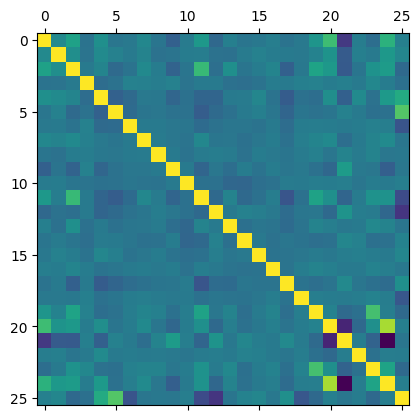

In [21]:
plt.matshow(df.corr())

## Prepare train/test split

In [10]:
test_df = df[df["release_date"] == 2019]
train_df = df[df["release_date"] < 2019]

In [11]:
test_y = test_df["genre"].astype(int)
test_x = test_df.drop(["genre"], axis=1)

In [12]:
test_x.describe()

,release_date,len,dating,violence,world/life,night/time,shake the audience,family/gospel,romantic,communication,...,family/spiritual,like/girls,sadness,feelings,danceability,loudness,acousticness,instrumentalness,valence,energy
count,534.0,534.000000,534.000000,534.000000,534.000000,534.000000,534.000000,534.000000,534.000000,534.000000,...,534.000000,534.000000,534.000000,534.000000,534.000000,534.000000,534.000000,534.000000,534.000000,534.000000
mean,2019.0,90.129213,0.016683,0.122035,0.094104,0.045951,0.026875,0.013068,0.020531,0.067742,...,0.021071,0.034463,0.084090,0.025680,0.621312,0.735271,0.176979,0.052762,0.517527,0.676547
std,0.0,44.822478,0.037044,0.178047,0.152553,0.096376,0.049217,0.038573,0.063985,0.100685,...,0.043791,0.068706,0.148218,0.060631,0.174233,0.074512,0.227364,0.181792,0.225448,0.176812
min,2019.0,5.000000,0.000333,0.000333,0.000337,0.000349,0.000384,0.000349,0.000333,0.000337,...,0.000333,0.000349,0.000356,0.000337,0.128127,0.124529,0.000018,0.000000,0.021744,0.096068
25%,2019.0,57.250000,0.000789,0.000940,0.000923,0.000881,0.000957,0.000774,0.000752,0.000917,...,0.000774,0.000849,0.000849,0.000810,0.507473,0.705420,0.015285,0.000000,0.343570,0.564551
50%,2019.0,83.000000,0.001253,0.007018,0.002449,0.001645,0.001949,0.001253,0.001196,0.002105,...,0.001350,0.001422,0.001671,0.001422,0.634463,0.746378,0.068021,0.000005,0.519270,0.698689
75%,2019.0,117.000000,0.004685,0.175790,0.112215,0.047967,0.035553,0.003053,0.003053,0.107797,...,0.018937,0.039947,0.103730,0.028946,0.745478,0.782267,0.266817,0.001126,0.690849,0.806551
max,2019.0,199.000000,0.282232,0.927126,0.732057,0.706536,0.402632,0.502873,0.793171,0.481625,...,0.319756,0.495549,0.743528,0.519390,0.970757,0.885624,0.963855,0.993927,0.975268,0.990991


In [13]:
train_y = train_df["genre"].astype(int)
train_x = train_df.drop(["genre"], axis=1)

## Prepare classifiers

In [14]:
def test_classifier(train_x, train_y, test_x, test_y, classifier_fun, class_params=None):
    if (class_params != None):
        cls = OneVsRestClassifier(classifier_fun(**class_params))
    else:
        cls = classifier_fun()
    
    cls.fit(train_x, train_y)

    preds = cls.predict(test_x)

    ret = {}
    ret["mean_acc"] = cls.score(test_x, test_y)
    # ret["predictions"] = preds
    # ret["accuracy"] = accuracy_score(test_y, preds)
    # ret["f1score"] = f1_score(test_y, preds)
    # ret["roc_auc"] = roc_auc_score(test_y, preds)

    return ret["mean_acc"]
    

In [15]:
classifiers = [KNeighborsClassifier, GaussianNB, DecisionTreeClassifier, RandomForestClassifier]

In [16]:
results = {}

for cls in classifiers:
    results[cls.__name__] = test_classifier(train_x, train_y, test_x, test_y, cls)
    

In [17]:
results

{'KNeighborsClassifier': 0.3258426966292135,
 'GaussianNB': 0.398876404494382,
 'DecisionTreeClassifier': 0.36704119850187267,
 'RandomForestClassifier': 0.5037453183520599}

In [18]:
# predict majority class accuraccy:
train_y.value_counts() # genre 4 is most common

genre
4    6963
1    5373
0    4526
6    3958
3    3794
5    2440
2     784
Name: count, dtype: int64

In [19]:
np.sum(test_y == 4)/len(test_y)

0.14794007490636704